In [1]:
from utils.functions import *

In [2]:
N_max_r = 255
N_max_comb_r = 255
s_min_r = 2 # 2 per mlp
m_min_r = 8 # width
s_min_comb_r = 2
m_min_comb_r = 8
M_r = 2
B_default_r = 4
L_default_r = 4
rho_default = 0.1

In [3]:
L_fixed = 5
M_fixed = 2
s_min_values = [1, 2, 4]   # one panel per s_min (s_min_comb = s_min)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

# ---- Global style tweaks: bigger fonts/ticks everywhere ----
plt.rcParams.update({
    "font.size": 14,          # base font
    "axes.titlesize": 18,     # subplot titles
    "axes.labelsize": 16,     # axis labels
    "xtick.labelsize": 13,    # tick labels
    "ytick.labelsize": 13,
    "legend.fontsize": 13,
})
s_mid = 2


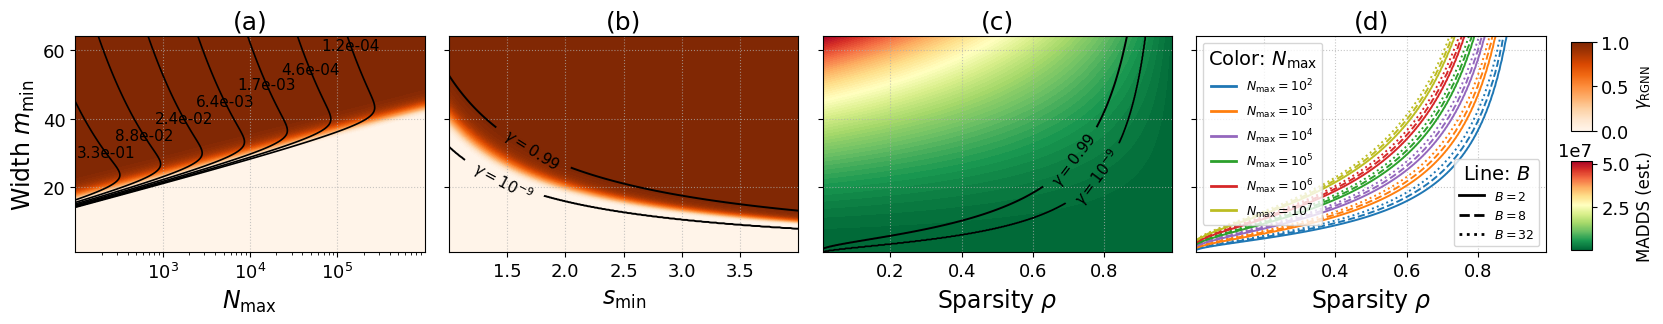

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

# ----------------- Fallbacks for required constants (keeps your session if already defined) -----------------
try: L_fixed
except NameError: L_fixed = 5
try: B_default_r
except NameError: B_default_r = 4
try: M_r
except NameError: M_r = 2
try: s_min_r
except NameError: s_min_r = 2
try: s_min_comb_r
except NameError: s_min_comb_r = 2
try: N_max_r
except NameError: N_max_r = 1000
try: N_max_comb_r
except NameError: N_max_comb_r = N_max_r

# ----------------- Shared settings / grids -----------------
rho_mid = 0.7
widths_shared = np.linspace(1, 64, 320)                 # <-- shared y-axis across all panels

# ----- Panel A data: x = N_max (log), y = width -----
N_vals_A = np.logspace(2.0001, 5.999, 320)                       # 1e2 ... 1e6
gamma_grid_A = np.zeros((len(N_vals_A), len(widths_shared)), dtype=float)
cost_grid_A  = np.zeros_like(gamma_grid_A, dtype=float)

for i, N_curr in enumerate(N_vals_A):
    for j, m_min in enumerate(widths_shared):
        gamma_grid_A[i, j] = gamma_rgnn_lower_bound(
            N_max=N_curr, s_min=s_min_r, m_min=m_min,
            N_max_comb=N_curr, s_min_comb=s_min_comb_r, m_min_comb=m_min,
            rho=rho_mid, L=L_fixed, M=M_r, B=B_default_r, use_simplified=False
        )
        cost_grid_A[i, j] = rgnn_madds_estimate(
            N_max=N_curr, N_max_comb=N_curr,
            m_min=m_min, m_min_comb=m_min,
            B=B_default_r, M=M_r, L=L_fixed, sparsity=rho_mid
        )

eps = 1e-12
eff_per_M_A = 1e6 * gamma_grid_A / (cost_grid_A + eps)
eff_pos_A = eff_per_M_A[eff_per_M_A > 0]
if eff_pos_A.size >= 8 and np.isfinite(eff_pos_A).all():
    levels_eff_A = np.geomspace(np.percentile(eff_pos_A, 20),
                                np.percentile(eff_pos_A, 95), 7)
else:
    levels_eff_A = np.geomspace(1e-6, 1e-2, 7)

# ----- Panel D data: x = s_min, y = width -----
s_vals_D = np.linspace(1.001, 3.999, 320)
gamma_grid_D = np.zeros((len(s_vals_D), len(widths_shared)), dtype=float)
for i, s_val in enumerate(s_vals_D):
    for j, m_min in enumerate(widths_shared):
        gamma_grid_D[i, j] = gamma_rgnn_lower_bound(
            N_max=N_max_r, s_min=s_val, m_min=m_min,
            N_max_comb=N_max_r, s_min_comb=s_val, m_min_comb=m_min,
            rho=rho_mid, L=L_fixed, M=M_r, B=B_default_r, use_simplified=False
        )

# ----- Panel C data: x = rho, y = width -----
rhos_C = np.linspace(0.01, 0.99, 600)
madds_grid_C = np.zeros((len(widths_shared), len(rhos_C)), dtype=float)
gamma_grid_C = np.zeros_like(madds_grid_C, dtype=float)
for j, rho in enumerate(rhos_C):
    for i, m_min in enumerate(widths_shared):
        gamma_grid_C[i, j] = gamma_rgnn_lower_bound(
            N_max=N_max_r, s_min=s_min_r, m_min=m_min,
            N_max_comb=N_max_comb_r, s_min_comb=s_min_comb_r, m_min_comb=m_min,
            rho=rho, L=L_fixed, M=M_r, B=B_default_r, use_simplified=False
        )
        madds_grid_C[i, j] = rgnn_madds_estimate(
            N_max=N_max_r, N_max_comb=N_max_comb_r,
            m_min=m_min, m_min_comb=m_min,
            B=B_default_r, M=M_r, L=L_fixed, sparsity=rho
        )

# ----- Panel B data: γ=0.99 frontiers only, x = rho, y = width -----
rhos_B   = np.linspace(0.01, 0.99, 160)
N_values_B = [100, 1000, 10000, 100000, 1000000, 10000000]
B_values_B = [2, 8, 32]
colors_N_B = {
    100: "tab:blue", 1000: "tab:orange", 10000: "tab:purple",
    100000: "tab:green", 1000000: "tab:red", 10000000: "tab:olive",
}
styles_B_B = {2: "-", 8: "--", 32: ":"}
gamma_target_B = 0.99

# ----------------- Plot (A, D, C, B) with shared y -----------------
fig, axes = plt.subplots(1, 4, figsize=(17, 4.5*0.6), sharey=True)

# Panel A
axA = axes[0]
cfA = axA.contourf(
    N_vals_A, widths_shared, gamma_grid_A.T,
    levels=np.linspace(0, 1, 51), cmap=cm.Oranges, vmin=0.0, vmax=1.0
)
csA = axA.contour(
    N_vals_A, widths_shared, eff_per_M_A.T,
    levels=levels_eff_A, colors="black", linewidths=1.2
)
# horizontal labels for efficiency contours
#textsA = axA.clabel(csA, fmt=lambda v: f"{v:.1e}", inline=False, fontsize=11)
#for t in textsA:
#    t.set_rotation(0)
#    t.set_rotation_mode('anchor')

# choose (N_max, m_min) positions where you want each label to appear
manual_pos_A = [
    (1e2, 30),
    (1e3, 35),
    (1e3+500, 40),
    (1e4, 45),
    (1e4+500, 50),
    (1e5, 55),
    (1e5+500, 60),
    # add as many as you want
]

textsA = axA.clabel(
    csA,
    fmt=lambda v: f"{v:.1e}",
    inline=False,
    fontsize=11,
    manual=manual_pos_A
)

for t in textsA:
    t.set_rotation(0)
    t.set_rotation_mode("anchor")


#axA.set_title(rf"γ-efficiency (ρ={rho_mid:.2f})")
axA.set_title("(a)")
axA.set_xlabel(r"$N_{\max}$", fontsize=17)
axA.set_ylabel(r"Width $m_{\min}$", fontsize=17)
axA.set_xscale("log")
axA.grid(True, ls=":", lw=0.8, alpha=0.7)

# Panel D
axD = axes[1]
cfD = axD.contourf(
    s_vals_D, widths_shared, gamma_grid_D.T,
    levels=np.linspace(0, 1, 51), cmap=cm.Oranges, vmin=0.0, vmax=1.0
)
csD = axD.contour(
    s_vals_D, widths_shared, gamma_grid_D.T,
    levels=[0.99], colors="black", linewidths=1.4
)
axD.clabel(csD, fmt={0.99: r"$\gamma=0.99$"}, inline=True, fontsize=11, manual=[[1.1, 2.3]])
'''
csD = axD.contour(
    s_vals_D, widths_shared, gamma_grid_D.T,
    levels=[0.5], colors="black", linewidths=1.4
)
axD.clabel(csD, fmt={0.5: r"$\gamma=0.5$"}, inline=True, fontsize=11, manual=[[1.1, 2.3]])
'''
csD = axD.contour(
    s_vals_D, widths_shared, gamma_grid_D.T,
    levels=[1e-9], colors="black", linewidths=1.4
)
axD.clabel(csD, fmt={1e-9: r"$\gamma=10^{-9}$"}, inline=True, fontsize=11, manual=[[1.1, 2.3]])

#axD.set_title(rf"γ landscape vs $s_{{\min}}$ (ρ={rho_mid:.2f})")
axD.set_title("(b)")
axD.set_xlabel(r"$s_{\min}$", fontsize=17)
axD.grid(True, ls=":", lw=0.8, alpha=0.7)

# Panel C
axC = axes[2]
cmapC = cm.RdYlGn_r
cfC = axC.contourf(
    rhos_C, widths_shared, madds_grid_C,
    levels=64, cmap=cmapC
)
levels_C = [0.99, 
            #0.5, 
            1e-9]
labels_C = {0.99: r"$\gamma=0.99$", 
            #0.50: r"$\gamma=0.50$", 
            1e-9: r"$\gamma=10^{-9}$"}
for lev in levels_C:
    cs = axC.contour(
        rhos_C, widths_shared, gamma_grid_C,
        levels=[lev], colors="black",
        linewidths=1.4 if lev == 0.99 else 1.2
    )
    axC.clabel(cs, fmt={lev: labels_C[lev]}, inline=True, fontsize=11, manual=[[1.1, 2.3]])

#axC.set_title(r"Cost landscape + γ frontiers")
axC.set_title("(c)")
axC.set_xlabel(r"Sparsity $\rho$", fontsize=17)
axC.grid(True, ls=":", lw=0.8, alpha=0.7)

# Panel B
axB = axes[3]
for N_max in N_values_B:
    for B_val in B_values_B:
        gamma_grid = np.zeros((len(widths_shared), len(rhos_B)), dtype=float)
        for i, m_min in enumerate(widths_shared):
            for j, rho in enumerate(rhos_B):
                gamma_grid[i, j] = gamma_rgnn_lower_bound(
                    N_max=N_max, s_min=s_mid, m_min=m_min,
                    N_max_comb=N_max, s_min_comb=s_mid, m_min_comb=m_min,
                    rho=rho, L=L_fixed, M=M_r, B=B_val, use_simplified=False
                )
        axB.contour(
            rhos_B, widths_shared, gamma_grid,
            levels=[gamma_target_B],
            colors=[colors_N_B[N_max]],
            linestyles=styles_B_B[B_val],
            linewidths=1.4,
        )
#axB.set_title(rf"γ = {gamma_target_B} frontiers (s$_{{\min}}$={s_min_r})")
axB.set_title("(d)")
axB.set_xlabel(r"Sparsity $\rho$", fontsize=17)
axB.grid(True, ls=":", lw=0.8, alpha=0.7)

# --- Legends inside Panel B (rightmost) ---
from matplotlib.lines import Line2D  # ensure this import is present at top
'''
legend_colors = [
    Line2D([0], [0], color=colors_N_B[N], lw=2, label=rf"$N_{{\max}}={N}$")
    for N in N_values_B
]
'''
legend_colors = [
    Line2D(
        [0], [0],
        color=colors_N_B[N], lw=2,
        label=rf"$N_{{\max}}=10^{{{int(np.round(np.log10(N)))}}}$"
    )
    for N in N_values_B
]

legend_styles = [
    Line2D([0], [0], color="black", lw=2, linestyle=styles_B_B[b], label=rf"$B={b}$")
    for b in B_values_B
]

leg1 = axB.legend(
    handles=legend_colors,
    title=r"Color: $N_{\max}$",
    loc="upper left",
    fontsize=9,
    frameon=True
)
axB.add_artist(leg1)

axB.legend(
    handles=legend_styles,
    title=r"Line: $B$",
    loc="lower right",
    fontsize=9,
    frameon=True
)

# Colorbars (left: γ for A/D; right: MADDS for C)
caxA = fig.add_axes([0.935, 0.57, 0.012, 0.33])
smA = cm.ScalarMappable(norm=Normalize(vmin=0, vmax=1), cmap=cm.Oranges)
smA.set_array([])
cbarA = fig.colorbar(smA, cax=caxA)
cbarA.set_label(r"$\gamma_{\mathrm{RGNN}}$", fontsize=12)

caxC = fig.add_axes([0.935, 0.13, 0.012, 0.33])
smC = cm.ScalarMappable(
    norm=Normalize(vmin=madds_grid_C.min(), vmax=madds_grid_C.max()),
    cmap=cmapC
)
smC.set_array([])
cbarC = fig.colorbar(smC, cax=caxC)
cbarC.set_label("MADDS (est.)", fontsize=12)

plt.subplots_adjust(left=0.055, right=0.92, wspace=0.07, bottom=0.12, top=0.92)
plt.savefig("composite_row_selected_panels_smin_shared_width_fixedshapes_swapped.pdf", bbox_inches="tight")
plt.show()


In [6]:
# ============================================================
# NO-TRAINING BASELINE (self-contained):
# Random-init tiny RGNN + random Bernoulli pruning
# Success criterion: all graph embeddings are pairwise distinct
# ============================================================
# This cell includes EVERYTHING it needs:
# - toy multi-relational dataset generator
# - tiny RGNN definition
# - pruning routine
# - embedding-distinctness success test
# - rho sweep + plot + table
#
# Dependencies: numpy, torch, matplotlib, pandas
# ------------------------------------------------------------

import copy
import math
import random
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd


# -----------------------------
# Reproducibility
# -----------------------------
def set_seed(seed: int = 0) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)
device = 'cpu'#torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


# -----------------------------
# Toy multi-relational graphs
# -----------------------------
@dataclass
class RelGraph:
    num_nodes: int
    edge_index_by_rel: List[torch.LongTensor]  # list of [2, E_r] tensors

    def to(self, dev: torch.device) -> "RelGraph":
        self.edge_index_by_rel = [ei.to(dev) for ei in self.edge_index_by_rel]
        return self


def _make_undirected_edge_index(edges_undirected: List[Tuple[int, int]]) -> torch.LongTensor:
    """Undirected -> directed both ways: returns edge_index [2, E]."""
    src, dst = [], []
    for u, v in edges_undirected:
        src.append(u); dst.append(v)
        if u != v:
            src.append(v); dst.append(u)
    return torch.tensor([src, dst], dtype=torch.long)


def _sample_edges_undirected(num_nodes: int, p: float, rng: np.random.Generator) -> List[Tuple[int, int]]:
    edges = []
    for u in range(num_nodes):
        for v in range(u + 1, num_nodes):
            if rng.random() < p:
                edges.append((u, v))
    return edges


def graph_signature(g: RelGraph) -> Tuple:
    """Cheap uniqueness heuristic: degree sequence per relation + edge count per relation."""
    sig = []
    for ei in g.edge_index_by_rel:
        deg = torch.bincount(ei[0], minlength=g.num_nodes).cpu().numpy()
        sig.append(tuple(sorted(deg.tolist())))
        sig.append(int(ei.shape[1] // 2))  # approx undirected edge count
    return tuple(sig)


def generate_toy_dataset(
    num_graphs: int = 60,
    num_nodes: int = 8,
    num_relations: int = 3,
    ps: Optional[List[float]] = None,
    seed: int = 0,
    max_tries: int = 200_000,
) -> List[RelGraph]:
    """
    Generates a set D of multi-relational graphs with diverse (approx) structures.
    """
    if ps is None:
        ps = [0.12, 0.20, 0.28]
        if len(ps) < num_relations:
            ps = ps + [ps[-1]] * (num_relations - len(ps))
        ps = ps[:num_relations]

    rng = np.random.default_rng(seed)
    graphs: List[RelGraph] = []
    seen = set()

    tries = 0
    while len(graphs) < num_graphs and tries < max_tries:
        tries += 1
        eis = []
        for r in range(num_relations):
            edges = _sample_edges_undirected(num_nodes, ps[r], rng)
            # avoid degenerate empty relation
            if len(edges) == 0:
                u = int(rng.integers(0, num_nodes))
                v = int(rng.integers(0, num_nodes - 1))
                if v >= u:
                    v += 1
                edges = [(u, v)]
            eis.append(_make_undirected_edge_index(edges))

        g = RelGraph(num_nodes=num_nodes, edge_index_by_rel=eis)
        sig = graph_signature(g)
        if sig in seen:
            continue
        seen.add(sig)
        graphs.append(g)

    if len(graphs) < num_graphs:
        raise RuntimeError(f"Generated only {len(graphs)} unique graphs after {tries} tries.")
    return graphs


graphs = generate_toy_dataset(num_graphs=30, num_nodes=6, num_relations=3, seed=0) #30 8 3
print("Generated graphs:", len(graphs), "relations:", len(graphs[0].edge_index_by_rel))

# -----------------------------
# Simple structural node features
# -----------------------------
def node_features_degrees(g: RelGraph) -> torch.FloatTensor:
    """
    Features: [1, deg_rel0, deg_rel1, ..., deg_relR-1] per node.
    Constructed on the same device as edges.
    """
    dev = g.edge_index_by_rel[0].device
    degs = []
    for ei in g.edge_index_by_rel:
        deg = torch.bincount(ei[0], minlength=g.num_nodes).to(dev).float()
        degs.append(deg.unsqueeze(1))
    deg_mat = torch.cat(degs, dim=1)  # [N, R]
    ones = torch.ones((g.num_nodes, 1), device=dev, dtype=torch.float32)
    return torch.cat([ones, deg_mat], dim=1)  # [N, 1+R]


# -----------------------------
# Extremely simple RGNN
# -----------------------------
def mean_aggregate(num_nodes: int, edge_index: torch.LongTensor, h: torch.Tensor) -> torch.Tensor:
    """
    Mean aggregation over directed edges:
      out[v] = mean_{u -> v} h[u]
    """
    src, dst = edge_index[0], edge_index[1]
    out = torch.zeros_like(h)
    out.index_add_(0, dst, h[src])

    deg = torch.zeros((num_nodes,), device=h.device, dtype=h.dtype)
    deg.index_add_(0, dst, torch.ones_like(dst, dtype=h.dtype))
    deg = deg.clamp_min(1.0).unsqueeze(1)
    return out / deg

# -----------------------------
# Extremely simple RGNN
# -----------------------------
def sum_aggregate(num_nodes: int, edge_index: torch.LongTensor, h: torch.Tensor) -> torch.Tensor:
    """
    Sum aggregation over directed edges:
      out[v] = sum_{u -> v} h[u]

    Shapes:
      edge_index: [2, E]
      h:         [N, d]
      out:       [N, d]
    """
    src, dst = edge_index[0], edge_index[1]
    out = torch.zeros_like(h)
    out.index_add_(0, dst, h[src])
    return out


class TinyRGNN(nn.Module):
    """
    Minimal branches+combine RGNN:
      h0 = tanh(W_in x)
      for each layer:
         for each relation r: m_r = tanh(W_r meanAgg_r(h))
         h = tanh(W_c concat(h, m_1..m_R))
      graph_emb = sum_nodes(h)
    """
    def __init__(self, in_dim: int, hidden_dim: int, num_relations: int, num_layers: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_relations = num_relations
        self.num_layers = num_layers

        self.input_proj = nn.Linear(in_dim, hidden_dim, bias=False)

        self.branch_linears = nn.ModuleList([
            nn.ModuleList([nn.Linear(hidden_dim, hidden_dim, bias=False) for _ in range(num_relations)])
            for _ in range(num_layers)
        ])
        self.combine_linears = nn.ModuleList([
            #nn.Linear(hidden_dim * (num_relations + 1), hidden_dim, bias=False)
            nn.Linear(hidden_dim, hidden_dim, bias=False)
            for _ in range(num_layers)
        ])

    @torch.no_grad()
    def embed(self, g: RelGraph) -> torch.Tensor:
        """Return graph embedding vector [hidden_dim]."""
        g = copy.deepcopy(g).to(next(self.parameters()).device)
        x = node_features_degrees(g)  # already on correct device
        h = torch.tanh(self.input_proj(x))

        for l in range(self.num_layers):
            outs = []
            for r in range(self.num_relations):
                agg = sum_aggregate(g.num_nodes, g.edge_index_by_rel[r], h) #mean
                outs.append(torch.tanh(self.branch_linears[l][r](agg)))
            comb_in = torch.stack([h] + outs, dim=0).sum(dim=0)#torch.cat([h] + outs, dim=-1)
            h = torch.tanh(self.combine_linears[l](comb_in))

        return h.sum(dim=0)


# -----------------------------
# Pruning: Bernoulli keep-mask on weights
# -----------------------------
def masked_state_dict(
    base_sd: Dict[str, torch.Tensor],
    rho: float,
    rng: torch.Generator,
    prune_bias: bool = False,
) -> Dict[str, torch.Tensor]:
    """
    Apply Bernoulli(rho) mask to all floating tensors except biases (unless prune_bias=True).
    """
    out = {}
    for k, v in base_sd.items():
        if (not prune_bias) and (k.endswith(".bias") or k.endswith("bias")):
            out[k] = v.clone()
            continue
        if not torch.is_floating_point(v):
            out[k] = v.clone()
            continue
        probs = torch.full_like(v, float(rho), device=v.device)
        mask = torch.bernoulli(probs, generator=rng)
        out[k] = v * mask
    return out


# -----------------------------
# Success test: pairwise distinct embeddings
# -----------------------------
@torch.no_grad()
def pairwise_distinct_success(
    model: TinyRGNN,
    graphs: List[RelGraph],
    eps: float = 1e-6,
    normalize: bool = False,
) -> bool:
    """
    Success iff min_{i<j} ||e_i - e_j||_2 > eps.
    """
    model.eval()
    embs = []
    for g in graphs:
        embs.append(model.embed(g).unsqueeze(0))
    E = torch.cat(embs, dim=0)  # [G, d]

    if normalize:
        E = F.normalize(E, p=2, dim=1)

    if E.shape[0] < 2:
        return True

    dists = torch.pdist(E, p=2)
    min_dist = float(dists.min().item())
    return min_dist > eps


@torch.no_grad()
def empirical_success_probability(
    model: TinyRGNN,
    graphs: List[RelGraph],
    rho: float,
    trials: int = 200,
    seed: int = 0,
    prune_bias: bool = False,
    eps: float = 1e-6,
    normalize: bool = False,
) -> float:
    """
    Random pruning trials; return fraction of masks that keep embeddings pairwise distinct.
    """
    base_sd = {k: v.detach().clone() for k, v in model.state_dict().items()}
    successes = 0

    gen = torch.Generator(device=next(model.parameters()).device)
    gen.manual_seed(seed)

    for _ in range(trials):
        sd = masked_state_dict(base_sd, rho=rho, rng=gen, prune_bias=prune_bias)
        model.load_state_dict(sd, strict=True)
        if pairwise_distinct_success(model, graphs, eps=eps, normalize=normalize):
            successes += 1

    model.load_state_dict(base_sd, strict=True)
    return successes / trials


# -----------------------------
# Run the no-training baseline
# -----------------------------
hidden_dim = 8
num_layers = 3
num_relations = len(graphs[0].edge_index_by_rel)
in_dim = 1 + num_relations

rand_model = TinyRGNN(in_dim=in_dim, hidden_dim=hidden_dim, num_relations=num_relations, num_layers=num_layers).to(device)
rand_model.eval()

eps = 1e-6
normalize = False

print("Dense (unpruned) distinct?", pairwise_distinct_success(rand_model, graphs, eps=eps, normalize=normalize))

#rhos = [0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 0.30, 0.40, 0.50, 0.65, 0.80, 0.90, 1.00]
rhos = np.linspace(0.01,0.99,50)#np.arange(0.01, 0.99, 0.1)
trials = 100 # 100

emp_vals = []
for rho in rhos:
    p = empirical_success_probability(
        rand_model, graphs, rho=rho,
        trials=trials, seed=123,
        prune_bias=False,
        eps=eps, normalize=normalize
    )
    emp_vals.append(p)
    print(f"rho={rho:>5.2f} | empirical_success={p:>6.3f}")

'''
# Plot
plt.figure()
plt.plot(rhos, emp_vals, marker="o")
plt.xlabel("rho (Bernoulli keep probability)")
plt.ylabel("P( all graph embeddings pairwise distinct )")
plt.ylim(-0.05, 1.05)
plt.title("No-training baseline: random-init RGNN, pruning success by embedding distinctness")
plt.show()

df = pd.DataFrame({"rho": rhos, "empirical_success": emp_vals})
df
'''

Device: cpu
Generated graphs: 30 relations: 3
Dense (unpruned) distinct? True
rho= 0.01 | empirical_success= 0.000
rho= 0.03 | empirical_success= 0.010


KeyboardInterrupt: 

In [ ]:
# ============================================================
# Compare empirical pruning success vs gamma lower bound
# (NO-TRAINING baseline: random-init model)
# Assumes in your notebook:
#   - graphs, rand_model, rhos, empirical_success_probability(...) already exist
#   - gamma_rgnn_lower_bound(...) is defined (your provided code)
# ============================================================

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# ---------- 1) Collect "MLP inputs" from the random-init model ----------
@torch.no_grad()
def collect_branch_and_comb_inputs(model: TinyRGNN, graphs: List[RelGraph]):
    """
    Collects:
      - branch_inputs: the tensors that go into each per-relation linear (we use 'agg')
      - comb_inputs:   the tensors that go into the combine linear (we use 'comb_in')

    Returns numpy arrays:
      branch_all: [N_total, hidden_dim]
      comb_all:   [N_total, hidden_dim*(B+1)]
    """
    model.eval()
    dev = next(model.parameters()).device

    branch_list = []
    comb_list = []

    for g in graphs:
        g = copy.deepcopy(g).to(dev)

        x = node_features_degrees(g)
        h = torch.tanh(model.input_proj(x))

        for l in range(model.num_layers):
            outs = []
            for r in range(model.num_relations):
                agg = sum_aggregate(g.num_nodes, g.edge_index_by_rel[r], h)  # [N, d]
                branch_list.append(agg.detach().cpu().numpy())
                outs.append(torch.tanh(model.branch_linears[l][r](agg)))

            comb_in = torch.stack([h] + outs, dim=0).sum(dim=0)#torch.cat([h] + outs, dim=-1)  # [N, d*(B+1)]
            comb_list.append(comb_in.detach().cpu().numpy())
            h = torch.tanh(model.combine_linears[l](comb_in))

    branch_all = np.concatenate(branch_list, axis=0)
    comb_all = np.concatenate(comb_list, axis=0)
    return branch_all, comb_all


# ---------- 2) Estimate N_max and s_min (approx, via rounding) ----------
def unique_rows_rounded(x: np.ndarray, decimals: int = 3) -> np.ndarray:
    xr = np.round(x, decimals=decimals)
    return np.unique(xr, axis=0)

def s_min_l0(unique_x: np.ndarray, tol: float = 0.0, max_pairs: int = 200_000, seed: int = 0) -> float:
    """
    Approximate s_min = min_{i<j} ||x_i - x_j||_0, counting coordinates with |diff|>tol.
    Uses exact all-pairs if small enough, otherwise random pair sampling.
    """
    n, d = unique_x.shape
    if n < 2:
        return float(d)

    num_pairs = n * (n - 1) // 2
    rng = np.random.default_rng(seed)

    # exact if not too many pairs
    if num_pairs <= max_pairs:
        smin = d
        for i in range(n):
            diffs = (np.abs(unique_x[i+1:] - unique_x[i]) > tol)
            if diffs.size == 0:
                continue
            l0s = diffs.sum(axis=1)
            smin = min(smin, int(l0s.min()))
            if smin <= 1:
                break
        return float(max(1, smin))

    # otherwise sample pairs
    smin = d
    for _ in range(max_pairs):
        i = int(rng.integers(0, n))
        j = int(rng.integers(0, n - 1))
        if j >= i:
            j += 1
        l0 = int((np.abs(unique_x[i] - unique_x[j]) > tol).sum())
        smin = min(smin, l0)
        if smin <= 1:
            break
    return float(max(1, smin))


def estimate_bound_stats_from_random_init(
    model: TinyRGNN,
    graphs: List[RelGraph],
    round_decimals: int = 3,
    tol: float = 0.0,
    max_pairs: int = 200_000,
) -> dict:
    branch_all, comb_all = collect_branch_and_comb_inputs(model, graphs)

    branch_unique = unique_rows_rounded(branch_all, decimals=round_decimals)
    comb_unique   = unique_rows_rounded(comb_all,   decimals=round_decimals)

    N_max = float(branch_unique.shape[0])
    N_max_comb = float(comb_unique.shape[0])

    s_min = s_min_l0(branch_unique, tol=tol, max_pairs=max_pairs, seed=0)
    s_min_comb = s_min_l0(comb_unique, tol=tol, max_pairs=max_pairs, seed=1)

    return dict(
        N_max=N_max,
        s_min=s_min,
        N_max_comb=N_max_comb,
        s_min_comb=s_min_comb,
        m_min=float(model.hidden_dim),
        m_min_comb=float(model.hidden_dim),
    )


stats = estimate_bound_stats_from_random_init(
    rand_model,
    graphs,
    round_decimals=3,   # try 2 or 1 if N_max becomes enormous and gamma collapses to 0 everywhere
    tol=0.0,
    max_pairs=200_000,
)
print("Estimated bound stats (random-init, approximate):")
for k, v in stats.items():
    print(f"  {k:>11s}: {v}")


# ---------- 3) Compute gamma curve ----------
def gamma_curve_for_model(stats: dict, rhos: list, model: TinyRGNN, use_simplified: bool = True):
    L = int(model.num_layers)
    B = int(model.num_relations)
    M = 1  # in this toy: one linear per branch and one combine -> treat as M=1
    gammas = []
    for rho in rhos:
        gammas.append(
            gamma_rgnn_lower_bound(
                N_max=stats["N_max"],
                s_min=stats["s_min"],
                m_min=stats["m_min"],
                N_max_comb=stats["N_max_comb"],
                s_min_comb=stats["s_min_comb"],
                m_min_comb=stats["m_min_comb"],
                rho=1-float(rho), # Here, rho is pruning
                L=L,
                M=M,
                B=B,
                use_simplified=use_simplified,
            )
        )
    return gammas

gamma_vals = gamma_curve_for_model(stats, rhos, rand_model, use_simplified=False)

'''
# ---------- 4) Recompute empirical success (if you want it reproducible in this cell) ----------
# If you already computed emp_vals earlier, you can comment this block out and reuse it.
trials = 100
eps = 1e-6
normalize = False

emp_vals = []
for rho in rhos:
    p = empirical_success_probability(
        rand_model, graphs, rho=rho,
        trials=trials, seed=123,
        prune_bias=False,
        eps=eps, normalize=normalize
    )
    emp_vals.append(p)
'''

# ---------- 5) Plot + table ----------
df_cmp = pd.DataFrame({
    "rho": rhos,
    "empirical_success": emp_vals,
    "gamma_lower_bound": gamma_vals,
})
#print(df_cmp)

# For plotting on log-ish scale even when some values are 0:
emp_plot = np.maximum(np.array(emp_vals, dtype=float), 1e-12)
gam_plot = np.maximum(np.array(gamma_vals, dtype=float), 1e-12)


In [ ]:
# ============================================================
# EXPERIMENTS:
# (1) Correlation: pre-training expressivity vs post-training loss/acc
# (2) Correlation: pre-training expressivity vs gradient flow over training
#
# Assumes you already have in your notebook:
#   - graphs : List[RelGraph]
#   - node_features_degrees(g)
#   - sum_aggregate(num_nodes, edge_index, h)
# ============================================================

import copy
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# Trainable TinyRGNN + classifier head
# (matches your "sum aggregate + sum combine + tanh" design)
# -----------------------------
class TrainableTinyRGNN(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, num_relations: int, num_layers: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_relations = num_relations
        self.num_layers = num_layers

        self.input_proj = nn.Linear(in_dim, hidden_dim, bias=False)

        self.branch_linears = nn.ModuleList([
            nn.ModuleList([nn.Linear(hidden_dim, hidden_dim, bias=False) for _ in range(num_relations)])
            for _ in range(num_layers)
        ])
        self.combine_linears = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim, bias=False)
            for _ in range(num_layers)
        ])

    def embed(self, g):
        # IMPORTANT: no deepcopy + gradients enabled
        x = node_features_degrees(g)
        h = torch.tanh(self.input_proj(x))

        for l in range(self.num_layers):
            outs = []
            for r in range(self.num_relations):
                agg = sum_aggregate(g.num_nodes, g.edge_index_by_rel[r], h)  # [N, d]
                outs.append(torch.tanh(self.branch_linears[l][r](agg)))      # [N, d]
            comb_in = torch.stack([h] + outs, dim=0).sum(dim=0)              # [N, d]
            h = torch.tanh(self.combine_linears[l](comb_in))                 # [N, d]

        return h.sum(dim=0)  # graph emb [d]


class TinyRGNNClassifier(nn.Module):
    def __init__(self, backbone: TrainableTinyRGNN, num_classes: int):
        super().__init__()
        self.backbone = backbone
        self.head = nn.Linear(backbone.hidden_dim, num_classes, bias=True)

    def forward_logits(self, graphs):
        embs = [self.backbone.embed(g).unsqueeze(0) for g in graphs]  # list of [1,d]
        E = torch.cat(embs, dim=0)                                    # [G,d]
        return self.head(E), E


# -----------------------------
# Expressivity metrics (pre-training)
# -----------------------------
@torch.no_grad()
def pretrain_expressivity_scores(model: TinyRGNNClassifier, graphs, eps: float = 1e-6):
    model.eval()
    logits, E = model.forward_logits(graphs)
    # pairwise distances among embeddings
    if E.shape[0] < 2:
        return dict(min_dist=float("inf"), distinct=True, num_unique=int(E.shape[0]))

    dists = torch.pdist(E, p=2)                 # [G*(G-1)/2]
    min_dist = float(dists.min().item())
    distinct = (min_dist > eps)

    # "num unique" up to tolerance by rounding (a cheap proxy)
    Er = torch.round(E / eps) * eps
    num_unique = int(torch.unique(Er, dim=0).shape[0])

    return dict(min_dist=min_dist, distinct=bool(distinct), num_unique=num_unique)


# -----------------------------
# Fixed-mask pruning utilities (keep mask fixed during training)
# -----------------------------
def sample_weight_masks(model: nn.Module, keep_prob: float, seed: int = 0, prune_bias: bool = False):
    """
    Returns dict[name] = mask tensor in {0,1} for each parameter.
    """
    gen = torch.Generator(device=next(model.parameters()).device)
    gen.manual_seed(seed)

    masks = {}
    for name, p in model.named_parameters():
        if (not prune_bias) and ("bias" in name):
            masks[name] = torch.ones_like(p, dtype=p.dtype, device=p.device)
            continue
        probs = torch.full_like(p, float(keep_prob), device=p.device)
        masks[name] = torch.bernoulli(probs, generator=gen)
    return masks


@torch.no_grad()
def apply_masks_(model: nn.Module, masks: dict):
    for name, p in model.named_parameters():
        p.mul_(masks[name])


@torch.no_grad()
def mask_grads_(model: nn.Module, masks: dict):
    for name, p in model.named_parameters():
        if p.grad is None:
            continue
        p.grad.mul_(masks[name])


def global_grad_norm(model: nn.Module) -> float:
    """
    Evci-style 'Gradient Norm' proxy: L2 norm of gradient over parameters.
    """
    sq = 0.0
    for p in model.parameters():
        if p.grad is None:
            continue
        sq += float(p.grad.detach().pow(2).sum().item())
    return float(math.sqrt(sq))


# -----------------------------
# Training loop: full-batch graph-ID classification under fixed mask
# -----------------------------
def train_one_run(
    graphs,
    keep_prob: float,
    hidden_dim: int = 8,
    num_layers: int = 3,
    lr: float = 1e-2,
    weight_decay: float = 0.0,
    epochs: int = 200,
    seed_model: int = 0,
    seed_mask: int = 123,
    eps_expressivity: float = 1e-6,
    device: str = "cpu",
):
    # labels = graph IDs
    num_classes = len(graphs)
    y = torch.arange(num_classes, device=device)

    # build model with deterministic init (so only mask varies if you vary seed_mask)
    torch.manual_seed(seed_model)
    num_relations = len(graphs[0].edge_index_by_rel)
    in_dim = 1 + num_relations

    backbone = TrainableTinyRGNN(in_dim, hidden_dim, num_relations, num_layers).to(device)
    model = TinyRGNNClassifier(backbone, num_classes=num_classes).to(device)

    # move graphs to device (deepcopy to avoid mutating original)
    gs = [copy.deepcopy(g).to(torch.device(device)) for g in graphs]

    # sample fixed masks and apply once
    masks = sample_weight_masks(model, keep_prob=keep_prob, seed=seed_mask, prune_bias=False)
    apply_masks_(model, masks)

    # pre-training expressivity
    expr = pretrain_expressivity_scores(model, gs, eps=eps_expressivity)

    # train
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    grad_norms = []
    losses = []
    accs = []

    model.train()
    for ep in range(epochs):
        opt.zero_grad(set_to_none=True)
        logits, E = model.forward_logits(gs)          # [G,C], [G,d]
        loss = F.cross_entropy(logits, y)
        loss.backward()

        # keep mask fixed
        mask_grads_(model, masks)
        gn = global_grad_norm(model)
        grad_norms.append(gn)

        opt.step()
        apply_masks_(model, masks)

        with torch.no_grad():
            pred = logits.argmax(dim=1)
            acc = (pred == y).float().mean().item()
            losses.append(float(loss.item()))
            accs.append(float(acc))

    # summarize "gradient flow over training"
    grad_norms = np.asarray(grad_norms, dtype=float)
    mean_grad_norm = float(np.mean(grad_norms))
    mean_log10_grad_norm = float(np.mean(np.log10(grad_norms + 1e-12)))  # matches log-scale plots

    out = dict(
        keep_prob=float(keep_prob),
        sparsity=float(1.0 - keep_prob),
        init_min_dist=float(expr["min_dist"]),
        init_distinct=int(expr["distinct"]),
        init_num_unique=int(expr["num_unique"]),
        final_loss=float(losses[-1]),
        final_acc=float(accs[-1]),
        mean_grad_norm=mean_grad_norm,
        mean_log10_grad_norm=mean_log10_grad_norm,
    )
    return out


# -----------------------------
# Run sweeps + compute correlations
# -----------------------------
def corr_pearson_spearman(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    # pearson
    x0 = x - x.mean()
    y0 = y - y.mean()
    pearson = float((x0 @ y0) / (np.linalg.norm(x0) * np.linalg.norm(y0) + 1e-12))

    # spearman (rank corr)
    rx = x.argsort().argsort().astype(float)
    ry = y.argsort().argsort().astype(float)
    rx0 = rx - rx.mean()
    ry0 = ry - ry.mean()
    spearman = float((rx0 @ ry0) / (np.linalg.norm(rx0) * np.linalg.norm(ry0) + 1e-12))

    return pearson, spearman


def run_experiments(
    graphs,
    keep_probs=np.linspace(0.10, 0.99, 10),
    runs_per_keep: int = 20,
    epochs: int = 200,
    lr: float = 1e-2,
    hidden_dim: int = 8,
    num_layers: int = 3,
    device: str = "cpu",
):
    rows = []
    for kp in keep_probs:
        for t in range(runs_per_keep):
            row = train_one_run(
                graphs=graphs,
                keep_prob=float(kp),
                hidden_dim=hidden_dim,
                num_layers=num_layers,
                lr=lr,
                epochs=epochs,
                seed_model=0,         # fixed init across all runs
                seed_mask=1000 + t,   # vary mask
                device=device,
            )
            rows.append(row)

    df = pd.DataFrame(rows)

    '''
    # ---- Experiment 1: expressivity vs training outcome ----
    # Choose an expressivity scalar: init_min_dist is usually the best continuous one.
    pear_acc, spear_acc = corr_pearson_spearman(df["init_min_dist"], df["final_acc"])
    pear_loss, spear_loss = corr_pearson_spearman(df["init_min_dist"], df["final_loss"])

    # ---- Experiment 2: expressivity vs gradient flow ----
    pear_gf, spear_gf = corr_pearson_spearman(df["init_min_dist"], df["mean_log10_grad_norm"])

    print("=== Exp 1: pre-training expressivity vs post-training metrics ===")
    print(f"corr(init_min_dist, final_acc):  Pearson={pear_acc:+.3f}, Spearman={spear_acc:+.3f}")
    print(f"corr(init_min_dist, final_loss): Pearson={pear_loss:+.3f}, Spearman={spear_loss:+.3f}")

    print("\n=== Exp 2: pre-training expressivity vs gradient flow over training ===")
    print(f"corr(init_min_dist, mean_log10_grad_norm): Pearson={pear_gf:+.3f}, Spearman={spear_gf:+.3f}")
    '''
    return df


# -----------------------------
# Example call (edit to your liking)
# -----------------------------
df = run_experiments(
     graphs,
     keep_probs=np.linspace(0.01, 0.99, 50),
     runs_per_keep=20,
     epochs=10,
     lr=1e-2,
     hidden_dim=8,
     num_layers=3,
     device="cpu",
 )
df.head()


In [ ]:
df['init_num_unique_ratio'] = df['init_num_unique']/30
df_init_distinct = df.groupby('sparsity').std()['init_num_unique_ratio']
df_init_distinct[(df_init_distinct.index >= 0.75) & (df_init_distinct.index <= 0.95)].std()

df_grouped = df.groupby('sparsity').mean()
df_grouped.head()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scp
from matplotlib.lines import Line2D

# -------------------------
# Left panel data (dumbbell)
# -------------------------
x = 1 - rhos
emp = np.asarray(emp_plot)
bnd = np.asarray(gam_plot)

# -------------------------
# Right panel data (Spearman rho vs -log10(p))
# -------------------------
df_grouped = df.groupby("sparsity").mean(numeric_only=True)

tests = [
    ("mean_grad_norm", "Flow"),
    ("final_loss",     "Loss"),
    ("final_acc",      "Acc."),
]

rows = []
x_var = df_grouped["init_num_unique_ratio"]

for col, label in tests:
    y_var = df_grouped[col]
    if x_var.nunique() < 2 or y_var.nunique() < 2:
        rho, p = np.nan, np.nan
    else:
        rho, p = scp.spearmanr(x_var, y_var)

    rows.append({
        "test": label,
        "rho": rho,
        "p": p,
        "neglog10p": (-np.log10(p) if (p is not None and p > 0) else np.nan)
    })

res = pd.DataFrame(rows)
print(res)

# -------------------------
# Combined figure
# -------------------------
fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(7.0, 2.2),
    constrained_layout=True,
    gridspec_kw={"width_ratios": [1.0, 1.0]}
)

# ===== (a) dumbbell plot =====
ax1.vlines(x, bnd, emp, linewidth=2, alpha=0.7, color="tab:orange", label=r"$\Delta_{\gamma}$")
ax1.scatter(x, emp, s=50, marker="^", alpha=1.0, color="tab:green", label=r"$\gamma_{\mathrm{empirical}}$", edgecolors="black", linewidths=0.4)
ax1.scatter(x, bnd, s=50, marker="v", alpha=1.0, color="tab:red",   label=r"$\gamma_{\mathrm{RGNN}}$", edgecolors="black", linewidths=0.4)

ax1.set_xlabel(r"Sparsity $\rho$")
ax1.set_ylabel(r"$\gamma$")
ax1.set_ylim(-0.1, 1.1)
ax1.legend(loc="lower left", frameon=True)
ax1.set_axisbelow(True)
ax1.grid(True, which="major", linestyle="-", linewidth=0.6, alpha=0.35)
ax1.set_title("(a)")

# ===== (b) rho vs -log10(p) =====
color_map = {"Flow": "tab:brown", "Loss": "tab:grey", "Acc.": "tab:cyan"}

for _, r in res.iterrows():
    ax2.scatter(
        r["rho"], r["neglog10p"],
        s=50,
        color=color_map.get(r["test"], "tab:gray"),
        edgecolors="black", linewidths=0.4
    )

# manual legend (clean, no duplicates)
legend_handles = [
    Line2D([0], [0], marker="o", linestyle="None", markersize=7,
           markerfacecolor=color_map[k], markeredgecolor="black", label=k)
    for k in ["Flow", "Loss", "Acc."]
]
ax2.legend(handles=legend_handles, loc="upper center", frameon=True, handlelength=1.0, ncol=2)

ax2.set_ylim(0, 6)
ax2.axhline(-np.log10(0.05), linewidth=1, linestyle="--", alpha=0.6)
ax2.set_xlabel("Spearman's $\\rho_{sm}$.")
ax2.set_ylabel(r"$-\log_{10}(p)$")
ax2.grid(True, linestyle="-", linewidth=0.6, alpha=0.25)
ax2.set_axisbelow(True)
ax2.set_title("(b)")

plt.savefig("combined_empirical_and_corr.pdf", bbox_inches="tight")
plt.show()
